In [1]:
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.diagnostics.targets import BeamDiagnostics
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam.beam_generator import make_beam, Gauss, rGauss
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Параметры
time_step       = 1000
time_limit      = 20000.5
window_length   = 15
window_width    = 3
r_step          = 0.05
xi_step         = 0.05

In [3]:
# Config
config = default_config
config.set('time-step', time_step)
config.set('time-limit', time_limit)
config.set('window-length', window_length)
config.set('window-width', window_width)
config.set('r-step', r_step)
config.set('xi-step', xi_step)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-window_length, vmax=0),
                r_distr=rGauss(vmin=0, vmax=window_width),
                ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                pz_distr=Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None),
                Ipeak_kA=2*40/1000,
                q_m=1/m_proton,
                saveto=".")

diagnostics = [
    BeamDiagnostics(period=20000)
]

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)

In [4]:
!rm beamfile.bin

In [5]:
sim.step(int(time_limit//time_step))

Number of particles: 119551
Number of particles in the middle layer: 200


In [6]:
!rm ../c_code/*
!cp beamfile.bin ../c_code/beamfile.bin
config.c_config('../c_code/lcode.cfg')
!echo 0 > ../c_code/beamfile.bit 

p = subprocess.Popen(["/home/global/lcode/lcode", "lcode.cfg"], cwd="../c_code")
p.wait()

0

In [7]:
particle_dtype = np.dtype([('xi', 'f8'), ('r', 'f8'), ('p_z', 'f8'), ('p_r', 'f8'), ('M', 'f8'), ('q_m', 'f8'),
                           ('q_norm', 'f8'), ('id', 'i8')])
beam_before = np.fromfile("beamfile.bin", dtype = particle_dtype)[:-1]
beam_c = np.fromfile("../c_code/beamfile.bin", dtype=particle_dtype)[:-1]
beam_python = diagnostics[0].data[int(time_limit//time_step)*time_step]


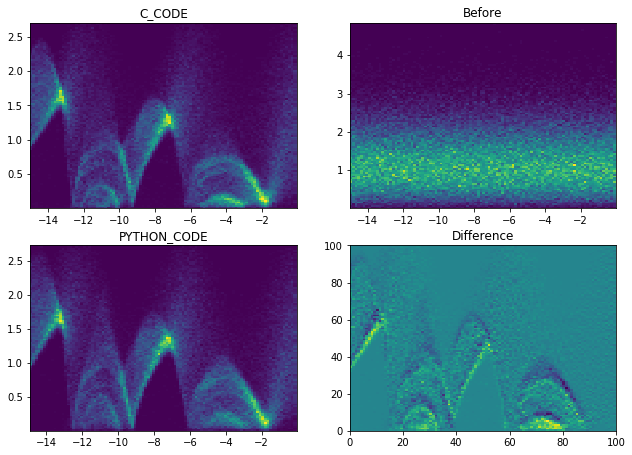

In [8]:
bins = 100
plt.subplot(222)
plt.hist2d(beam_before['xi'], beam_before['r'], bins=bins);
plt.title('Before')
plt.subplot(221)
c_hist = plt.hist2d(beam_c['xi'], beam_c['r'], bins=bins)[0]
plt.title('C_CODE')
plt.subplot(223)
py_hist = plt.hist2d(beam_python['xi'], beam_python['r'], bins=bins)[0]
plt.title('PYTHON_CODE')
plt.subplot(224)
plt.pcolormesh((c_hist-py_hist).T)
plt.title("Difference")

fig = plt.gcf()
fig.set_size_inches(10.5, 7.5)
plt.plot();